Title: Activation Suppressor

About this Technique:
As the name suggests, this techniques is used to suppress the activated regions in the final layer so that the model is forced to look at some other regions on the image. We can say that this is kind of a regularization technique. In this technique, we will maintain a base model which is trained on the original data. Next, we will pass each image from the training data to the model and find the top five activation regions in the image and suppress them. Here, suppression in the sense, we will fill those regions with neutral colors like gray (It is same as paint brush in the Photoshop) and also, we will apply a stylizing effect like oil painting, cartoonization, etc so that the model is forced to understand the structure rather than pixel level information.
The main advantage of this technique is that it is adaptive based on the current model's understanding on the subjects in the image. And also this technique is very efficient as whatever the new data being generated it is based on the performance of the model and we are only teaching the model where it is lagging. And another pattern we found it that it always have a positive effect on the model. Like if we suppress in the background regions, the model is directed to look for a suitable subject and also if we suppress some parts of the subject, then the model is directed to look for some other features of the subject.

Loading Required Libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import cv2 as cv
import numpy as np
import copy
import pathlib as pl
from tensorflow.keras.models import Model

Loading a trained model on the original data (in this case 3000 images of cats and dogs)

In [2]:
model = keras.models.load_model(r"Model generated\Perfect Model with C layer 1 flip 1 + ac1.2 + llr 1.h5")

In [3]:
#This is the architecture of the model which we are using
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 298, 298, 32)      896       
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 298, 298, 32)      0         
                                                                 
 depthwise_conv2d_15 (Depthw  (None, 298, 298, 32)     128       
 iseConv2D)                                                      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 149, 149, 32)     0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 149, 149, 32)      0         
                                                                 
 conv2d_18 (Conv2D)          (None, 147, 147, 64)     

In [4]:
# Here, we are extracting the outputs in filter in each layer
features = keras.Model(inputs=model.inputs, outputs=[layer.output for layer in model.layers])

In [16]:
#Here, we are filtering which types of layers we want to analyze
layer_names = []
for layer in model.layers:
    layer_names.append(layer.__class__.__name__)
types_of_layers = ["Conv2D", "MaxPooling2D", "Activation", "ReLU", "LeakyReLU"]
req = []
for i in range(len(layer_names)):
    if layer_names[i] in types_of_layers:
        req.append(i)

In [17]:
#Using this function, we will get the coordinates of activation areas
def relative_coordinates_getter_circle(activation_area):
    global dim
    pixel_ratio = 300/dim
    relative_y = int((activation_area[1]/dim)*300)
    relative_x = int((activation_area[0]/dim)*300)
    return(relative_y, relative_x)

In [18]:
#Using this function, we will apply some effect on the image like cartoonizing, oil paint, etc.
#The reason is to make sure that the model does not fixate on pixel values as we have already shown that image to the model.
def oilpaint(img):
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (2, 2))
    morph = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)
    result = cv.normalize(morph, None, 50, 255, cv.NORM_MINMAX)
    return result

In [19]:
#Using this function, the areas of activations is colored with neural color (grey)
def supress_circle(img, center):
    global dim
    cv.circle(img, (center), int(300/(dim+5)), (128, 128, 128), -1)
    return diffuser(img, center)
    #return img

In [20]:
#Using this function, we will gradient the edges of the circle as CNN is sensitive to edges
def diffuser(img, center):
    global dim
    blured = cv.GaussianBlur(img, (31, 31), 0)
    mask = np.zeros((300, 300, 3), dtype=np.uint8)
    cv.circle(mask, (center), int(300/(dim+3)), (255, 255, 255), -1)
    out = np.where(mask==np.array([255, 255, 255]), blured, img)
    return out

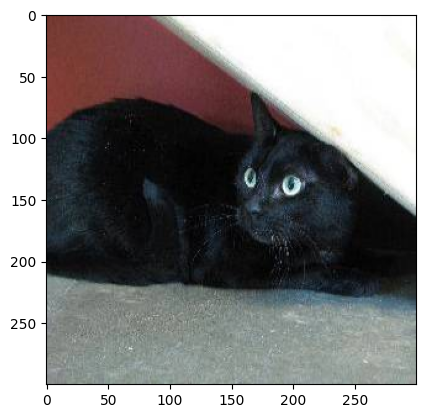

In [21]:
#This is an image from the training dataset and the model which we loaded is trained on these images
path = r"D:\Samsung Prism\Datasets\Cat and Dog\Training\Cat\cat.700.jpg"
img = cv.imread(path)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img = cv.resize(img, (300, 300))
plt.imshow(img)

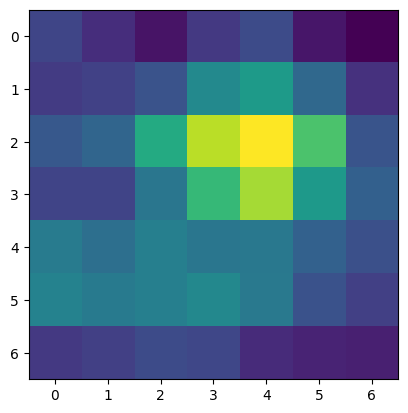

<Figure size 640x480 with 0 Axes>

In [22]:
#Finding the activation areas

n_suppressions = 2
feature_extractor = features(np.expand_dims(img/255.0, 0))
l_features = feature_extractor[req[-1]].numpy()[0]
dim = len(l_features[..., 0])
final_img = np.zeros((dim, dim))
for i in range(len(l_features[0][0])):
    final_img = final_img + l_features[..., i]
plt.imshow(final_img)
plt.figure()
#Till here, we have got the output of the final layer. This output contains the activation regions.
#Next, we are going to find the top five activated regions
top_five_activations = []
for i in range(n_suppressions):
    activation_area_1 = np.where(final_img == np.max(final_img))
    final_img[activation_area_1[0][0],activation_area_1[1][0]] = 0
    top_five_activations.append((activation_area_1[0][0],activation_area_1[1][0]) )
img = oilpaint(img)
for i in range(n_suppressions):
    # In each iteration, we are suppressing the activated regions
    img = supress_circle(img, relative_coordinates_getter_circle(top_five_activations[i]))

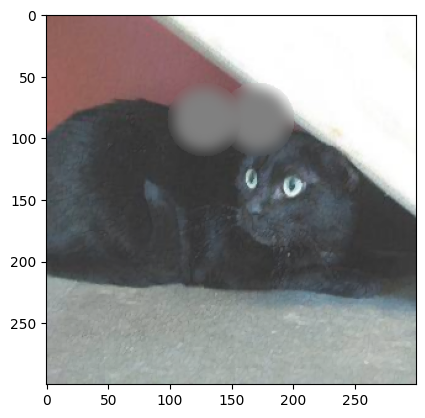

In [23]:
#These are the areas in the images using which the model is predicting this image as cat. Now, we will apply this suppression
#all images of the training dataset so that the model will be forced to learn other features like skin texture, ears, etc.
plt.imshow(img)

Now, this same suppression is applied on all the images from the training dataset and the model is trained again on these
images isolatedly and our test showed that by applying this technique till two levels improved the test accuracy on the general
data by 10-15%. The important thing is that, after applying this technique the CNN model is considering right regions to classify the image.

In [20]:
# For batch execution, pass the path of input file and output file

input_file_path = r"D:\Samsung Prism\Datasets\Cat and Dog\Training\Cat"
output_file_path = r"D:\Samsung Prism\Datasets\Temp"

# Functions for GPU implementation
def process_img(image, file_name):
    try:
        img = tf.io.decode_image(contents = image, channels=3, expand_animations=False)
        img = tf.image.resize(img, [300, 300])     
        return img
    except tf.errors.InvalidArgumentError as e:
        os.remove(file_name)   
        
def process_data(file_name):
    img = tf.io.read_file(file_name)
    img = process_img(img, file_name)
    img = img/255.0
    return img

def configure_inputs_train(data_set):
    data_set = data_set.batch(batch_size=8)
    data_set = data_set.prefetch(buffer_size=AUTOTUNE)
    return data_set

In [21]:
# Defining the input pipeline

AUTOTUNE = tf.data.AUTOTUNE
pathlib_file= pl.Path(input_file_path)
data_set = tf.data.Dataset.list_files(str(pathlib_file/"*"), shuffle=False)
AUTOTUNE = tf.data.AUTOTUNE
data_set = data_set.map(process_data, num_parallel_calls=AUTOTUNE)
data_set = configure_inputs_train(data_set)

In [22]:
# Filtering the final layer from which we need to get the feature map

layer_names = []
for layer in model.layers:
    layer_names.append(layer.__class__.__name__)
not_req = ["Flatten", "Dense", "Dropout", "GlobalMaxPooling2D"]
req = []
for i in range(len(layer_names)):
    if layer_names[i] not in not_req:
        req.append(i)
target_layer_index = req[-1]

# Making a new model that outputs a feature map directly
new_model = Model(inputs=model.inputs, outputs = model.layers[target_layer_index].output)
new_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")

In [24]:
# Finding all the activation maps
predictions = new_model.predict(data_set)

375/375 [==============================] - 19s 50ms/step


In [25]:
# Using the activation map of each image, applying the Activation Suppression augmentation

all_img_path = list(pathlib_file.glob("*"))
n_suppressions = 2
counter = 0
for i in all_img_path:
    img = cv.imread(str(i))
    img = cv.resize(img, (300, 300))
    activation = predictions[all_img_path.index(i), :, :, :]
    feature_map = np.zeros((activation.shape[0], activation.shape[0]))
    for i in range(activation.shape[-1]):
        feature_map += activation[:, :, i]
    final_img = feature_map/np.max(feature_map)
    dim = final_img.shape[0]
    top_five_activations = []
    for i in range(n_suppressions):
        activation_area_1 = np.where(final_img == np.max(final_img))
        final_img[activation_area_1[0][0],activation_area_1[1][0]] = 0
        top_five_activations.append((activation_area_1[0][0],activation_area_1[1][0]) )
    img = oilpaint(img)
    for i in range(n_suppressions):
        # In each iteration, we are suppressing the activated regions
        img = supress_circle(img, relative_coordinates_getter_circle(top_five_activations[i]))
    cv.imwrite(output_file_path + "\\" + "aug_as_"+str(counter) + ".jpg", img)
    counter += 1